## Preprocess your data using XCMS3 and export data files for feature-based molecular networking through GNPS

To follow this example tutorial, download the folder named <tt>'peak/AMG_Plant_subset'</tt> from the link below and place it under the same directory as your jupyter notebook: <br>
https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?task=de2d18fd91804785bce8c225cc94a444 <br>


Note that the settings for `xcms` used in this tutorial were not optimized,
specifically the alignment based on the default *obiwarp* parameters might
perform a little too strong retention time adjustment.
For more information on optimization of the parameters see the [xcms vignette](https://bioconductor.org/packages/release/bioc/vignettes/xcms/inst/doc/xcms.html)
or the [xcms preprocessing](https://jorainer.github.io/metabolomics2018/xcms-preprocessing.html) workshop.

Load required libraries and utility functions for GNPS export

In [2]:
library(xcms)
source("https://raw.githubusercontent.com/jorainer/xcms-gnps-tools/master/customFunctions.R")

Use socket based parallel processing on Windows systems. The number (`4`)
defines the number of parallel tasks. Adapt this setting to the number of CPUs
available on your system. Also note that it is usually better to not use all
CPUs of a system as a) during the analysis the MS data has to be imported from
the original mzML/mzXML/CDF files and it will thus be limited by the I/O of the
hard disks and b) the computer needs to have enough memory to load the complete
MS data of as many raw data files than there are parallel jobs. 

In [3]:
if (.Platform$OS.type == "unix") {
  register(bpstart(MulticoreParam(4)))
} else {
  register(bpstart(SnowParam(4)))
} 

### Load data

Load all .mzXML files and define sample grouping

In [4]:
mzMLfiles <- paste0('AMG_Plant_subset/',list.files(path = 'AMG_Plant_subset/', pattern = ".mzXML$", recursive = TRUE))
s_groups <- rep("sample", length(mzMLfiles))
pheno <- data.frame(sample_name = sub(basename(mzMLfiles), pattern = ".mzML",replacement = "", fixed = TRUE),
                    sample_group = s_groups, stringsAsFactors = FALSE)

In [5]:
head(pheno)

sample_name,sample_group
<chr>,<chr>
10712_P4_RH3_01_521.mzXML,sample
10715_P4_RA4_01_415.mzXML,sample
10765_P4_RE9_01_482.mzXML,sample
11035_P4_RB4_01_431.mzXML,sample
13917_P4_RA10_01_423.mzXML,sample
14153_P4_RH8_01_526.mzXML,sample


Read all raw data, including MS2 level

In [6]:
rawData <- readMSData(mzMLfiles, centroided. = TRUE, pdata = new("NAnnotatedDataFrame", pheno), mode = "onDisk")

Create a base peak chromatogram (BPC) of your data for visual inspection

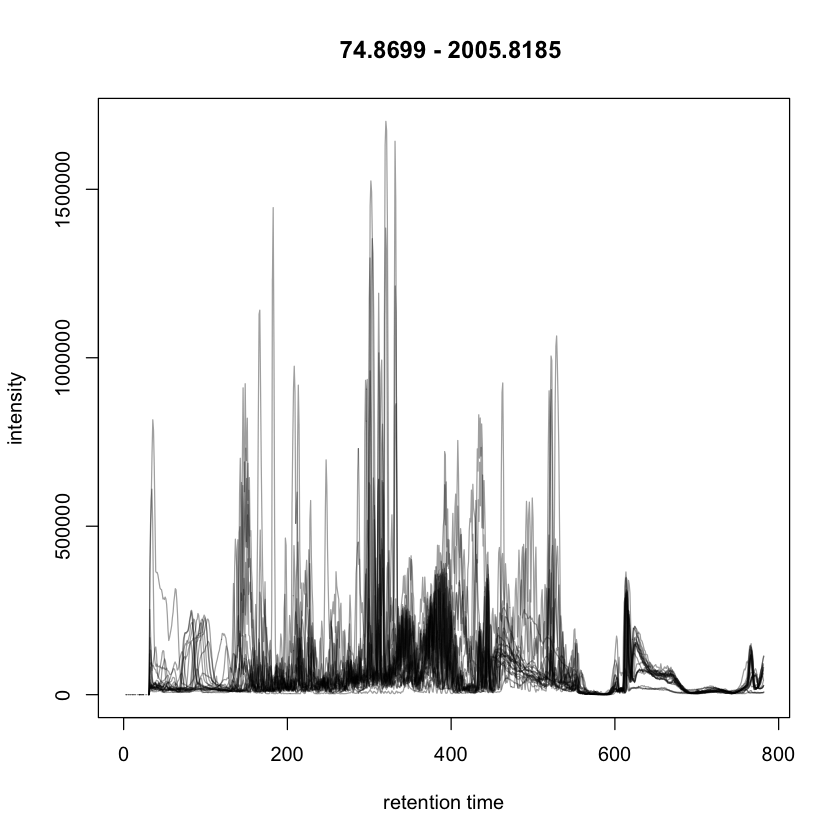

In [7]:
bpis <- chromatogram(rawData, aggregationFun = "max")
plot(bpis)

### Peak picking

Define settings for the centWave peak detection

In [8]:
cwp <- CentWaveParam(snthresh = 3, noise = 5000, peakwidth = c(5,30), ppm = 10)

Perform the chromatographic peak detection using *centWave*.

In [9]:
processedData <- findChromPeaks(rawData, param = cwp) 

Error in (function (x)  : attempt to apply non-function
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send e

Get an overview of the detected peaks, using a heatmap which represents the
number of peaks detected for each file along the retention time range

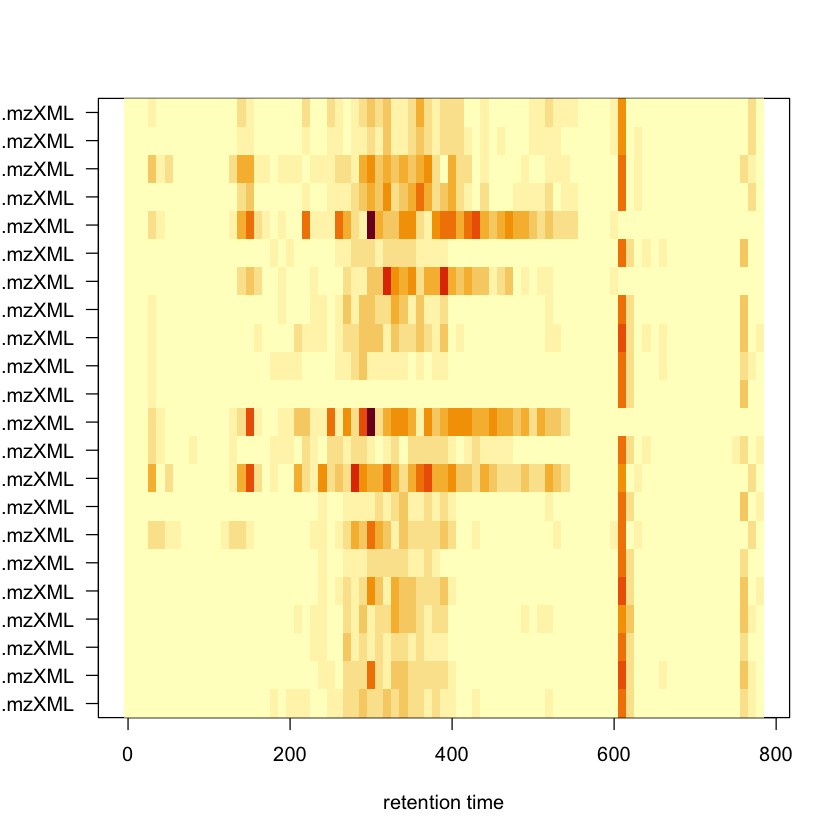

In [10]:
plotChromPeakImage(processedData, binSize = 10) 

### Retention time alignment

Do an *obiwarp*-based alignment using the default settings

In [11]:
processedData <- adjustRtime(processedData, param = ObiwarpParam())

Sample number 11 used as center sample.
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror

Plot the difference between adjusted and raw retention times.

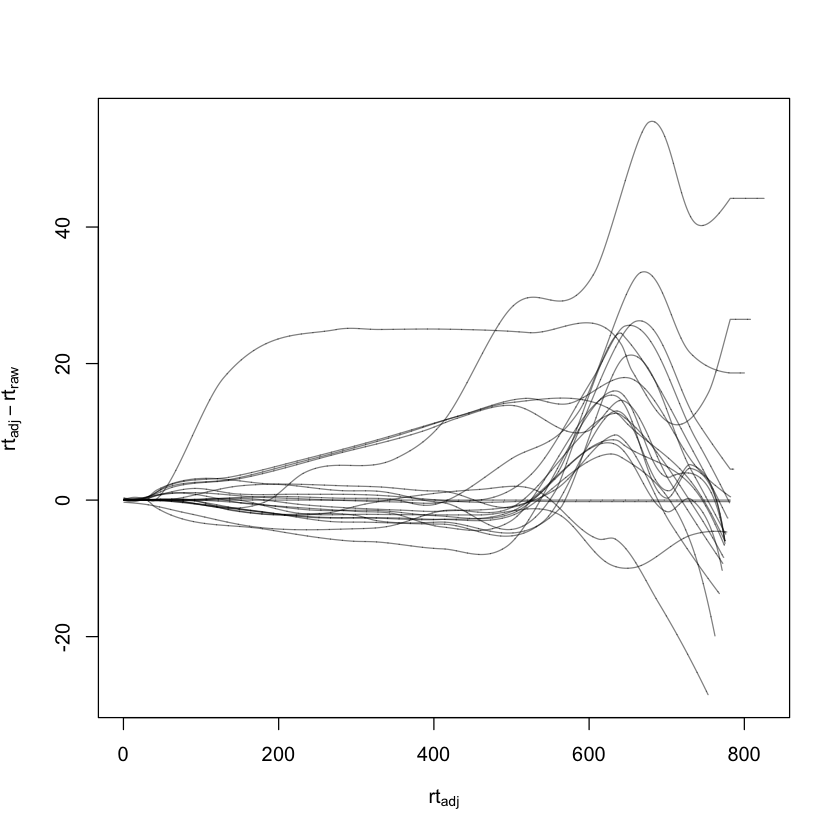

In [12]:
plotAdjustedRtime(processedData)

### Peak grouping

Define the parameters for the *peak density*-based peak grouping (correspondence
analysis)

In [13]:
pdp <- PeakDensityParam(sampleGroups = processedData$sample_group, minFraction = 0.10)
processedData <- groupChromPeaks(processedData, param = pdp) 

Processing 8792 mz slices ... OK


### Gap filling

Fill-in missing peaks. Peak detection might have failed for some features in
some samples. The `fillChromPeaks` function allows to integrate for such cases
all signal in the respective m/z - retention time range. Below we first define
the median width of identified chromatographic peaks in retention time dimension
and use this as parameter `fixedRt` for the `fillChromPeaks`.

In [14]:
medWidth <- median(chromPeaks(processedData)[, "rtmax"] -
                   chromPeaks(processedData)[, "rtmin"])
## fill missing peaks
processed_Data <- fillChromPeaks(processedData,
                                 param = FillChromPeaksParam(fixedRt = medWidth))

Defining peak areas for filling-in .... OK
Start integrating peak areas from original files
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Inte

### Export data

#### Export MS1 and MS2 features

Below we use the `featureSpectra` function to extract all MS2 spectra with their
precursor <i>m/z</i> being within the <i>m/z</i> range of a feature/peak and their retention
time within the rt range of the same feature/peak. Zero-intensity
values are removed from each spectrum with the `clean` function, and
subsequently processed into the expected format using the `formatSpectraForGNPS`
function.

In [15]:
## export the individual spectra into a .mgf file
filteredMs2Spectra <- featureSpectra(processedData, return.type = "Spectra")
filteredMs2Spectra@listData <- lapply(filteredMs2Spectra, clean, all = TRUE)
filteredMs2Spectra <- formatSpectraForGNPS(filteredMs2Spectra)

The extracted MS2 spectra are saved as *ms2spectra_all.mgf* file. This file can
for example be used to do *in silico* structure prediction through
[SIRIUS+CSI:FingerID](https://bio.informatik.uni-jena.de/software/sirius/). 

In [16]:
writeMgfData(filteredMs2Spectra, "ms2spectra_all.mgf")

Export peak area quantification table. To this end we first extract the *feature
definitions* (i.e. the <i>m/z</i> and retention time ranges and other metadata for all
defined features in the data set) and then the integrated peak areas (with the
`featureValues` function). This peak area quantification table contains features
and respective per sample peak areas in columns. The combined data is then saved
to the file *xcms_all.txt*. Note that it is now also possible to use the entire
feature table in the FBMN workflow.

In [17]:
## get data
featuresDef <- featureDefinitions(processedData)
featuresIntensities <- featureValues(processedData, value = "into")

## generate data table
dataTable <- merge(featuresDef, featuresIntensities, by=0, all=TRUE)
dataTable <- dataTable[,!(names(dataTable) %in% c("peakidx"))]

In [18]:
head(dataTable)

Row.names,mzmed,mzmin,mzmax,rtmed,rtmin,rtmax,npeaks,sample,10712_P4_RH3_01_521.mzXML,⋯,10546_P4_RG11_01_515.mzXML,11111_P4_RB1_01_428.mzXML,11163_P4_RB11_01_439.mzXML,12262_P1_RE5_01_94.mzXML,13541_P4_RG3_01_506.mzXML,14563_P1_RE10_01_99.mzXML,15581_P2_RD4_01_203.mzXML,15623_P2_RC3_01_187.mzXML,16500_P2_RD8_01_209.mzXML,16501_P2_RD9_01_210.mzXML
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FT0001,79.01876,79.01786,79.01983,632.6737,623.4913,671.0767,7,7,NA,⋯,NA,25194.60,41460.01,NA,NA,NA,37100.89,31792.34,NA,NA
FT0002,84.96011,84.95915,84.96119,632.3351,614.6725,672.1768,19,19,131536.75,⋯,133336.31,136480.93,123212.80,NA,128676.64,NA,146019.09,148656.29,142201.90,147074.26
FT0003,84.96008,84.95917,84.96123,768.7932,748.9986,816.4870,18,18,47386.26,⋯,44219.90,63143.97,63463.52,NA,56322.53,NA,33831.92,54578.64,41726.33,36886.44
FT0004,87.00476,87.00379,87.00583,631.4008,612.9404,671.0767,19,19,36743.51,⋯,39637.38,46997.92,46439.16,NA,37450.53,NA,40630.24,57949.78,42957.07,45581.79
FT0005,88.00500,88.00417,88.00608,629.6270,616.5360,668.8052,17,17,38299.19,⋯,32753.57,42393.10,44174.84,NA,39777.84,NA,29224.33,28941.75,22855.84,NA
FT0006,88.02374,88.02312,88.02502,768.6035,748.2793,815.6020,14,14,NA,⋯,52712.53,56453.99,40019.00,NA,NA,NA,38260.09,49078.86,NA,33403.81


In [19]:
write.table(dataTable, "xcms_all.txt", sep = "\t", quote = FALSE, row.names = FALSE)

#### Export MS2 features only

The `filteredMs2Spectra` contains all MS2 spectra with their precursor <i>m/z</i>
within the feature's <i>m/z</i> range and a retention time that is within the retention
time of the chromatographic peak/feature. We thus have multiple MS2 spectra for
each feature (also from each sample). Metadata column `"feature_id"` indicates
to which feature a MS2 spectrum belongs:

In [20]:
filteredMs2Spectra

Spectra with 34175 spectra and 2 metadata column(s):
                             msLevel     rtime peaksCount |  feature_id
                           <integer> <numeric>  <integer> | <character>
  FT0003.CP00804.F01.S4887         2   767.064          4 |      FT0003
  FT0003.CP00804.F01.S4923         2   770.735          1 |      FT0003
  FT0003.CP01616.F02.S4944         2   767.423          1 |      FT0003
  FT0003.CP02261.F03.S4901         2   794.810          0 |      FT0003
  FT0003.CP04436.F06.S4949         2   774.844          3 |      FT0003
                       ...       ...       ...        ... .         ...
  FT1481.CP16908.F18.S3292         2   504.908        947 |      FT1481
  FT1482.CP10400.F11.S3016         2   463.788       1081 |      FT1482
  FT1482.CP10400.F11.S3019         2   464.362       1470 |      FT1482
  FT1482.CP16781.F18.S3078         2   472.713       1332 |      FT1482
  FT1482.CP16781.F18.S3083         2   473.504       1140 |      FT1482
           

We next select a single MS2 spectrum for each feature and export this reduced
set also as an .mgf file. This file can be submitted to GNPS [feature-based
molecular
networking](https://ccms-ucsd.github.io/GNPSDocumentation/featurebasedmolecularnetworking/). As
*representative* MS2 spectrum for each feature we select the spectrum with the
largest total signal.

In [21]:
## Select for each feature the Spectrum2 with the largest TIC.
filteredMs2Spectra_maxTic <- combineSpectra(filteredMs2Spectra,
                                            fcol = "feature_id",
                                            method = maxTic)

In [22]:
writeMgfData(filteredMs2Spectra_maxTic, "ms2spectra_maxTic.mgf")

At last we subset the peak area quantification table to features for which we
have also an MS2 spectrum and export this to the *xcms_onlyMS2.txt* file. This
file can be submitted to GNPS [feature-based molecular
networking](https://ccms-ucsd.github.io/GNPSDocumentation/featurebasedmolecularnetworking/):

In [23]:
## filter data table to contain only peaks with MSMS DF[ , !(names(DF) %in% drops)]
filteredDataTable <- dataTable[which(dataTable$Row.names %in% filteredMs2Spectra@elementMetadata$feature_id),]

In [24]:
head(filteredDataTable)

,Row.names,mzmed,mzmin,mzmax,rtmed,rtmin,rtmax,npeaks,sample,10712_P4_RH3_01_521.mzXML,⋯,10546_P4_RG11_01_515.mzXML,11111_P4_RB1_01_428.mzXML,11163_P4_RB11_01_439.mzXML,12262_P1_RE5_01_94.mzXML,13541_P4_RG3_01_506.mzXML,14563_P1_RE10_01_99.mzXML,15581_P2_RD4_01_203.mzXML,15623_P2_RC3_01_187.mzXML,16500_P2_RD8_01_209.mzXML,16501_P2_RD9_01_210.mzXML
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,FT0003,84.96008,84.95917,84.96123,768.7932,748.9986,816.4870,18,18,47386.26,⋯,44219.90,63143.97,63463.52,NA,56322.53,NA,33831.92,54578.64,41726.33,36886.44
6,FT0006,88.02374,88.02312,88.02502,768.6035,748.2793,815.6020,14,14,NA,⋯,52712.53,56453.99,40019.00,NA,NA,NA,38260.09,49078.86,NA,33403.81
7,FT0007,88.02381,88.02301,88.02486,632.3018,613.8012,672.1768,19,19,106601.48,⋯,117296.73,143670.22,124281.27,NA,116959.66,NA,116065.87,134373.45,113570.83,111622.61
10,FT0010,97.01013,97.00943,97.01124,629.6270,611.2421,668.8052,19,19,104805.37,⋯,103491.04,116757.48,126878.14,NA,112133.41,NA,97458.39,104212.58,88544.07,92049.22
11,FT0011,97.01005,97.00962,97.01075,764.7314,751.1205,811.1670,13,13,37995.65,⋯,42610.06,44654.40,48893.62,NA,39757.19,NA,NA,NA,NA,NA
16,FT0016,98.51246,98.51178,98.51361,664.4330,612.9404,714.4675,76,19,406179.85,⋯,820176.67,1768152.28,962126.03,NA,524106.60,NA,270742.59,458656.61,556087.14,214308.59


In [25]:
write.table(filteredDataTable, "xcms_onlyMS2.txt", sep = "\t", quote = FALSE, row.names = FALSE)

#### Export MS2 consensus spectra

Alternatively, instead of selecting the spectrum with the largest total signal as representative MS2 spectrum for each feature, we can create a consensus MS2 spectrum. A consensus MS2 spectrum can for example be created by combining all MS2 spectra for a feature into a single spectrum that contains peaks present in the majority of spectra. 

To this end we can use the `combineSpectra` function. The parameter `minProp` defines the mimimal proportion of spectra in which a peak has to be present in order for it to be added to the consensus spectrum (0.8 -> 80% of spectra). The parameters `mzd` and `ppm` allow to define how to group peaks between spectra with `mzd` being a fixed, constant value and all peaks between spectra with a difference in their <i>m/z</i> < mzd are combined into the final mass peak in the consensus spectrum. Finally, the parameter `ppm` allows to perform an <i>m/z</i> dependent grouping of mass peaks, i.e. mass peaks with a difference in their <i>m/z</i> smaller than ppm are combined. 

For more details see the documentation of the [`consensusSpectrum`](https://rdrr.io/bioc/MSnbase/man/consensusSpectrum.html) function in the MSnbase R package.

In [26]:
filteredMs2Spectra_consensus <- combineSpectra(filteredMs2Spectra, fcol = "feature_id", method = consensusSpectrum,mzd = 0, minProp = 0.8, ppm = 10)

Warning message in FUN(X[[i]], ...):
“No peak present in more than 80% of spectra.”Warning message in FUN(X[[i]], ...):
“No peak present in more than 80% of spectra.”Warning message in FUN(X[[i]], ...):
“No peak present in more than 80% of spectra.”Warning message in FUN(X[[i]], ...):
“No peak present in more than 80% of spectra.”Warning message in FUN(X[[i]], ...):
“No peak present in more than 80% of spectra.”Warning message in FUN(X[[i]], ...):
“No peak present in more than 80% of spectra.”Warning message in FUN(X[[i]], ...):
“No peak present in more than 80% of spectra.”Warning message in FUN(X[[i]], ...):
“No peak present in more than 80% of spectra.”Warning message in FUN(X[[i]], ...):
“No peak present in more than 80% of spectra.”Warning message in FUN(X[[i]], ...):
“No peak present in more than 80% of spectra.”Warning message in FUN(X[[i]], ...):
“No peak present in more than 80% of spectra.”Warning message in FUN(X[[i]], ...):
“No peak present in more than 80% of spectra.”Warn

In [27]:
writeMgfData(filteredMs2Spectra_consensus, "ms2spectra_consensus.mgf")

Analogously we subset the peak area quantification table to features for which we
have an MS2 consensus spectrum and export this to the *xcms_consensusMS2.txt* file. This
file can be submitted to GNPS [feature-based molecular
networking](https://ccms-ucsd.github.io/GNPSDocumentation/featurebasedmolecularnetworking/):

In [28]:
## filter data table to contain only peaks with MSMS DF[ , !(names(DF) %in% drops)]
consensusDataTable <- dataTable[which(dataTable$Row.names %in% filteredMs2Spectra_consensus@elementMetadata$feature_id),]

In [29]:
head(consensusDataTable)

,Row.names,mzmed,mzmin,mzmax,rtmed,rtmin,rtmax,npeaks,sample,10712_P4_RH3_01_521.mzXML,⋯,10546_P4_RG11_01_515.mzXML,11111_P4_RB1_01_428.mzXML,11163_P4_RB11_01_439.mzXML,12262_P1_RE5_01_94.mzXML,13541_P4_RG3_01_506.mzXML,14563_P1_RE10_01_99.mzXML,15581_P2_RD4_01_203.mzXML,15623_P2_RC3_01_187.mzXML,16500_P2_RD8_01_209.mzXML,16501_P2_RD9_01_210.mzXML
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,FT0003,84.96008,84.95917,84.96123,768.7932,748.9986,816.4870,18,18,47386.26,⋯,44219.90,63143.97,63463.52,NA,56322.53,NA,33831.92,54578.64,41726.33,36886.44
6,FT0006,88.02374,88.02312,88.02502,768.6035,748.2793,815.6020,14,14,NA,⋯,52712.53,56453.99,40019.00,NA,NA,NA,38260.09,49078.86,NA,33403.81
7,FT0007,88.02381,88.02301,88.02486,632.3018,613.8012,672.1768,19,19,106601.48,⋯,117296.73,143670.22,124281.27,NA,116959.66,NA,116065.87,134373.45,113570.83,111622.61
10,FT0010,97.01013,97.00943,97.01124,629.6270,611.2421,668.8052,19,19,104805.37,⋯,103491.04,116757.48,126878.14,NA,112133.41,NA,97458.39,104212.58,88544.07,92049.22
11,FT0011,97.01005,97.00962,97.01075,764.7314,751.1205,811.1670,13,13,37995.65,⋯,42610.06,44654.40,48893.62,NA,39757.19,NA,NA,NA,NA,NA
16,FT0016,98.51246,98.51178,98.51361,664.4330,612.9404,714.4675,76,19,406179.85,⋯,820176.67,1768152.28,962126.03,NA,524106.60,NA,270742.59,458656.61,556087.14,214308.59


In [30]:
write.table(consensusDataTable, "xcms_consensusMS2.txt", sep = "\t", quote = FALSE, row.names = FALSE)